In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# The data 

In [2]:
DATA_DIR = '/Users/fletchercollis/Desktop/Machine learning for behavioral data/PROJECT_GoGYMi/GoGymi' ### put your path here

activity = pd.read_csv('{}/activity.csv'.format(DATA_DIR))


students = pd.read_csv('{}/students.csv'.format(DATA_DIR))
teachers = pd.read_csv('{}/teachers.csv'.format(DATA_DIR))


gymitrainer = pd.read_csv('{}/gymitrainer.csv'.format(DATA_DIR))


math_questions = pd.read_csv('{}/math_questions.csv'.format(DATA_DIR)) ### NOT USEFUL HERE YET SO NOT LOOKED AT OR CLEANED
text_questions = pd.read_csv('{}/text_questions.csv'.format(DATA_DIR)) ### NOT USEFUL HERE YET SO NOT LOOKED AT OR CLEANED
#texts = pd.read_csv('{}/texts.csv'.format(DATA_DIR)) ### NOT USEFUL HERE YET SO NOT LOOKED AT OR CLEANED


math_results = pd.read_csv('{}/math_results.csv'.format(DATA_DIR))
essay_results = pd.read_csv('{}/essay_results.csv'.format(DATA_DIR))
text_results = pd.read_csv('{}/text_results.csv'.format(DATA_DIR))

all_scores = pd.read_csv('{}/all_scores.csv'.format(DATA_DIR))

In [3]:
math_results

,Unnamed: 0,session_id,user_id,course_id,exam_id,question,points,max_points,time,hint_count,time_spent,correct
0,0,1,2437,42,2,1,0,1,1665067915,0,0,0
1,1,2,2437,42,2,2,0,1,1665069310,0,0,0
2,2,3,2437,42,2,3,0,1,1665070759,0,0,0
3,3,4,2437,42,2,6,0,1,1665074330,0,0,0
4,4,4,2437,42,2,7,0,1,1665074330,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
56802,56802,11990,955,42,37,869,1,1,1741330461,0,48,1
56803,56803,11990,955,42,37,870,1,1,1741330461,0,102,1
56804,56804,11990,955,42,37,871,1,1,1741330461,0,59,1
56805,56805,11990,955,42,37,872,1,1,1741330461,1,19,1


In [4]:
text_results

,Unnamed: 0,session_id,user_id,course_id,exam_id,question,points,max_points,time
0,0,f29259b3-adca-468e-a9c3-2a3ab76684c6-3,3174,2115,3,Aufgabe 2,1.0,1.0,1720874168
1,1,f29259b3-adca-468e-a9c3-2a3ab76684c6-3,3174,2115,3,Aufgabe 3,1.0,3.0,1720874193
2,2,f29259b3-adca-468e-a9c3-2a3ab76684c6-1,3174,2115,1,Aufgabe 1,0.0,1.0,1720874205
3,3,f29259b3-adca-468e-a9c3-2a3ab76684c6-1,3174,2115,1,Aufgabe 4a,0.0,2.0,1720874205
4,4,f29259b3-adca-468e-a9c3-2a3ab76684c6-1,3174,2115,1,Aufgabe 4b,0.0,2.0,1720874205
...,...,...,...,...,...,...,...,...,...
21283,21283,d2f58ed2-f73f-4afc-933f-1e05b12dbf17-1,3776,2115,1,Aufgabe 14.1,0.0,1.0,1736255136
21284,21284,d2f58ed2-f73f-4afc-933f-1e05b12dbf17-1,3776,2115,1,Aufgabe 14.2,0.0,1.0,1736255136
21285,21285,d2f58ed2-f73f-4afc-933f-1e05b12dbf17-1,3776,2115,1,Aufgabe 14.3,0.0,1.0,1736255136
21286,21286,d2f58ed2-f73f-4afc-933f-1e05b12dbf17-1,3776,2115,1,Aufgabe 14.4,0.0,1.0,1736255136


In [5]:
activity['time_spent'] = (activity['activity_updated'] - activity['activity_started'])

activity[activity['time_spent'] <= 0]

,Unnamed: 0,activity_id,user_id,post_id,course_id,activity_type,activity_status,activity_started,activity_completed,activity_updated,time_spent
0,75,1111,2533,1696,1696,access,0,1680884201,NaN,1680884201,0
14,89,1125,2533,1705,1696,lesson,0,1680885635,NaN,1680885635,0
15,90,1126,2533,1735,1696,topic,0,1680885638,NaN,1680885638,0
16,91,1127,2533,42,42,access,0,1689950337,0.000000e+00,1680885731,-9064606
18,93,1129,2533,55,42,lesson,0,1680885755,NaN,1680885755,0
...,...,...,...,...,...,...,...,...,...,...,...
72884,619,619,1653,2000619,2115,exam,1,1733167480,1.733167e+09,1733167480,0
72885,620,620,1828,2000620,2115,exam,1,1731932980,1.731933e+09,1731932980,0
72886,621,621,1607,2000621,2115,exam,1,1729668555,1.729669e+09,1729668555,0
72889,624,624,1629,2000624,2115,exam,1,1724696761,1.724697e+09,1724696761,0


# First, lets clean up the time in every dataframe to make it easier to manipulate!

In [6]:
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

students['creation_time'] = pd.to_datetime(students['creation_time'], unit='s')
teachers['creation_time'] = pd.to_datetime(teachers['creation_time'], unit='s')

gymitrainer['start_time'] = pd.to_datetime(gymitrainer['startTime'], unit='s')
gymitrainer['end_time'] = pd.to_datetime(gymitrainer['endTime'], unit='s')

math_results['time'] = pd.to_datetime(math_results['time'], unit='s')
essay_results['time'] = pd.to_datetime(essay_results['time'], unit='s')
text_results['time'] = pd.to_datetime(text_results['time'], unit='s')

all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')

# Cleaning the user data

## activity dataframe 

In [7]:
activity_og = activity.copy()

### Lets look at missing or problematic data 

- First lets see if there are any missing or problematic values and also drop "Unnamed: 0" column since it is not usefeul

In [8]:
activity = activity.drop('Unnamed: 0', axis=1)  

activity.isnull().sum().reset_index(name='Nb of NAN')

,index,Nb of NAN
0,activity_id,0
1,user_id,0
2,post_id,0
3,course_id,0
4,activity_type,0
5,activity_status,0
6,activity_started,0
7,activity_completed,31644
8,activity_updated,0
9,time_spent,0


- Only column where we have NAN and so we replace them with the last updated time and add a new column where 0 if uncompleted and 1 if completed

In the activity dataset in the activity_completed column, 0 or missing value both mean that the activity was never completed which either occurs if it was abandoned, or if the activity does not record when it is completed which is the case for access and exams from course ids 3301 and 5447 (these are related to the essays).

---> look into this 

In [9]:
activity['Completed'] = activity['activity_completed'].notna().astype(int)

## Quick check column is correct :
print(activity_og.shape[0] - activity['Completed'].sum())

31644


In [10]:
rows_where_updated_diff_from_completed_without_nan = activity[activity['activity_completed'] != activity['activity_updated']].shape[0] - (activity_og.shape[0] - activity['Completed'].sum())

print(rows_where_updated_diff_from_completed_without_nan)

### Updated time is the same as completed time except in 33933 cases when we take out the NAN this leaves : 

2289


In [11]:
activity.loc[:, 'activity_completed'] = activity['activity_completed'].fillna(activity['activity_updated'])  

In [12]:
activity.head()

,activity_id,user_id,post_id,course_id,activity_type,activity_status,activity_started,activity_completed,activity_updated,time_spent,Completed
0,1111,2533,1696,1696,access,0,2023-04-07 16:16:41,2023-04-07 16:16:41,2023-04-07 16:16:41,0,0
1,1112,2533,1696,1696,course,0,2023-04-07 16:16:45,1970-01-01 00:00:00,2023-04-07 16:40:34,1429,1
2,1113,2533,1699,1696,lesson,1,2023-04-07 16:16:45,2023-04-07 16:33:31,2023-04-07 16:33:31,1006,1
3,1114,2533,1769,1696,topic,1,2023-04-07 16:16:57,2023-04-07 16:18:08,2023-04-07 16:18:08,71,1
4,1115,2533,1711,1696,topic,1,2023-04-07 16:18:09,2023-04-07 16:31:59,2023-04-07 16:31:59,830,1


- Also we notice that some of the activity_completed column are from 1970-01-01 and so we replace them with the last updated time 

----> do we consider these completed or not? I consider them completed just that there was a bug

In [13]:
nb_of_unfeasible_dates = activity[activity['activity_completed'] < '2000-01-01'].shape[0]

print(rows_where_updated_diff_from_completed_without_nan - nb_of_unfeasible_dates)

### These also account for the majority of times the updated date is different from the completed one meaning we can assume updated = completed 

### (155 rows where this is not the case is negligeable for a dataset of 80000 rows)

155


In [14]:
activity.loc[activity['activity_completed'] < '2000-01-01', 'activity_completed'] = activity['activity_updated']

### Lets check the time spent on various activities

- Now we look at the time spent on activities

In [15]:
activity['time_spent'] = (activity['activity_updated'] - activity['activity_started']).dt.total_seconds()

activity.shape[0]

72897

In [16]:
activity['time_spent'].describe()

count    7.289700e+04
mean     5.597036e+05
std      1.886669e+06
min     -2.253558e+07
25%      0.000000e+00
50%      2.900000e+01
75%      2.689000e+03
max      3.388067e+07
Name: time_spent, dtype: float64

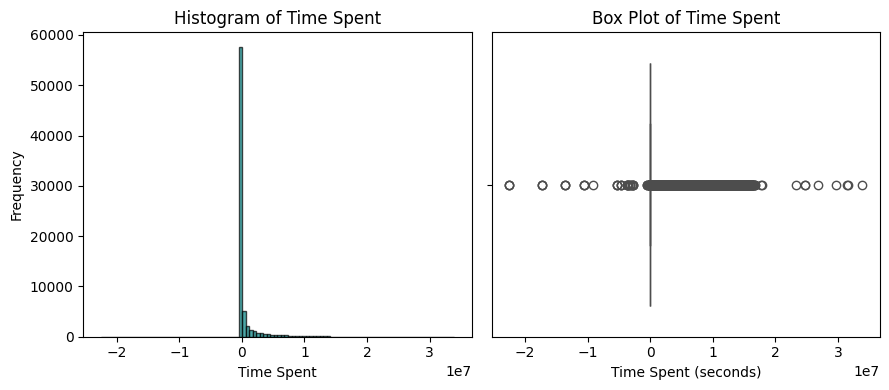

In [17]:
data = activity['time_spent'].copy()

fig, axes = plt.subplots(1, 2, figsize=(9, 4)) 


axes[0].hist(data, bins=100, color='teal', edgecolor='black', alpha=0.7)
axes[0].set_title('Histogram of Time Spent')
axes[0].set_xlabel('Time Spent')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=data, color='blue', ax=axes[1])
axes[1].set_title('Box Plot of Time Spent')
axes[1].set_xlabel('Time Spent (seconds)')

plt.tight_layout()
plt.show()

In [18]:
print('Nb of rows where the length of the activity is negative or zero:', activity[activity['time_spent'] < 0].shape[0])

Nb of rows where the length of the activity is negative or zero: 57


- Since there are few we decided to remove the problematic rows 

In [19]:
activity = activity[activity['time_spent'] >= 0]

- How much data did we lose?

In [20]:
activity_data_loss = activity.shape[0]/activity_og.shape[0]
print('Percent of original data lost', 100 - activity_data_loss * 100)

Percent of original data lost 0.07819251821062778


#### THIS IS ALOT SO MAYBE THINK ABOUT ALTERNATIVES?

- Now lets look at the distribution of time spent on activities

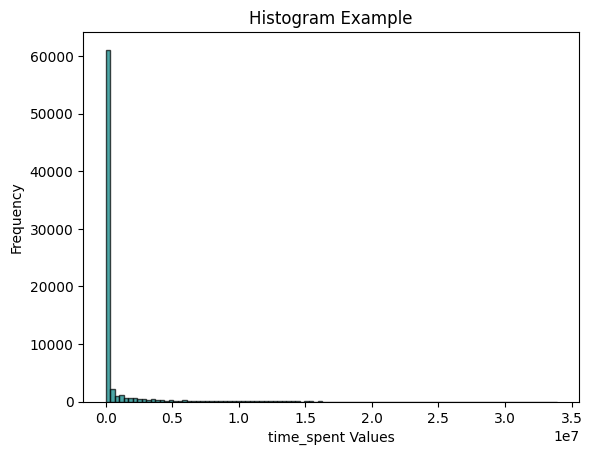

In [21]:
data = activity['time_spent']

plt.hist(data, bins=100, color='teal', edgecolor='black', alpha=0.7)
plt.title('Histogram Example')
plt.xlabel('time_spent Values')
plt.ylabel('Frequency')
plt.show()

- There seems to be some outliers, so lets remove some activities that seem to be taking too long -----> NEED TO DECIDE WHAT TOO LONG IS 

In [22]:
activity.groupby(by='activity_type')['time_spent'].describe()

,count,mean,std,min,25%,50%,75%,max
activity_type,,,,,,,,
access,717.0,8.416179e+01,1.178245e+03,0.0,0.00,0.0,6.00,18223.0
course,2507.0,3.458660e+06,4.556272e+06,0.0,1.00,1201645.0,5986228.50,33880667.0
exam,2619.0,1.056416e+03,9.569375e+03,0.0,0.00,0.0,0.00,236754.0
group_progress,48.0,5.920721e+06,4.551479e+06,324685.0,2649326.75,3628423.5,10536267.25,16518986.0
lesson,15436.0,7.565875e+05,2.202330e+06,0.0,0.00,0.0,100.00,16127845.0
quiz,6799.0,1.492692e+03,7.024486e+03,3.0,129.00,463.0,1331.50,446287.0
topic,44714.0,4.570039e+05,1.502307e+06,0.0,0.00,62.0,7355.00,26871427.0


In [23]:
quantiles = activity.groupby(by='activity_type')['time_spent'].quantile(0.95)

activity = activity[activity.apply(lambda row: row['time_spent'] <= quantiles[row['activity_type']], axis=1)]

- Now lets's see how much data deleted overall :

In [24]:
activity_data_loss = activity.shape[0]/activity_og.shape[0]
print('Percent of data lost in total', 100 - activity_data_loss * 100)

Percent of data lost in total 5.066052100909502


### Lets seperate the data out into Math, Text and Essay

Difference between "topic", "lesson" and "course" in activity.csv: a course is the highest level on the site. There are 8 courses of which a user will normally do 3-4. Inside of those courses are lessons which then have topics under them.

course ids 3301 and 5447 (these are related to the essays)

In [25]:
essay_course_ids =  [int(x) for x in list(essay_results['course'].unique())]
math_course_ids = [int(x) for x in list(math_results['course_id'].unique())]
text_course_ids = [int(x) for x in list(text_results['course_id'].unique())]

print('essay course IDs :', essay_course_ids)
print('math course IDs :', math_course_ids)
print('text course IDs :', text_course_ids)

essay course IDs : [5447, 3301]
math course IDs : [42, 3865, 3301, 5447, 0]
text course IDs : [2115, 5009]


In [26]:
activity['course_id'].unique()

array([1696,   42, 2019, 2115, 3865, 5447, 5009, 8117, 3301,    0, 2515,
       2440])

In [27]:
math_activity = activity[activity['course_id'].isin(math_course_ids)]
essay_activity = activity[activity['course_id'].isin(essay_course_ids)]
text_activity = activity[activity['course_id'].isin(text_course_ids)]

## Cleaning the test data

### all_scores datframe

In [28]:
all_scores_og = all_scores.copy()

- First lets see if there are any missing or problematic values

In [29]:
all_scores.isnull().sum().reset_index(name='Nb of NAN')

,index,Nb of NAN
0,Unnamed: 0,0
1,user_id,0
2,test_id,0
3,course,0
4,percentage,0
5,time,0


In [30]:
all_scores[all_scores['time'] < '2023-01-01']

,Unnamed: 0,user_id,test_id,course,percentage,time


- No problematic values so now let's see if some users redid the same exam more than once

In [31]:
attempt_count = all_scores.groupby(['user_id', 'test_id','course']).size().reset_index(name='attempt_count')

attempt_count[attempt_count['attempt_count'] > 1].shape[0]

441

- Let's get rid of everything past the first attempt ----> HERE DISCUSS

In [32]:
all_scores = all_scores.sort_values(by='time')

all_scores = all_scores.groupby(['user_id', 'test_id', 'course']).first().reset_index()

- Now lets's see how much data deleted overall :

In [33]:
all_scores_data_loss = all_scores.shape[0]/all_scores_og.shape[0]
print('Percent of data lost', 100 - all_scores_data_loss * 100)

Percent of data lost 23.647388059701484


- We also decided to round the "percentage" column to two decimal places to make life easier 

In [34]:
all_scores['percentage'] = all_scores['percentage'].round(2)

### Lets seperate the data out into Math, Text and Essay

course ids 3301 and 5447 (these are related to the essays)

In [35]:
essay_course_ids =  [int(x) for x in list(essay_results['course'].unique())]
math_course_ids = [int(x) for x in list(math_results['course_id'].unique())]
text_course_ids = [int(x) for x in list(text_results['course_id'].unique())]

print('essay course IDs :', essay_course_ids)
print('math course IDs :', math_course_ids)
print('text course IDs :', text_course_ids)

essay course IDs : [5447, 3301]
math course IDs : [42, 3865, 3301, 5447, 0]
text course IDs : [2115, 5009]


In [36]:
all_scores['course'].unique()

array([3301, 5447, 3865,   42, 2115, 5009])

In [37]:
math_scores = all_scores[all_scores['course'].isin(math_course_ids)]
essay_scores = all_scores[all_scores['course'].isin(essay_course_ids)]
text_scores = all_scores[all_scores['course'].isin(text_course_ids)]

# Now let's export our cleaned data !

Here will have 6 dataframes so far once seperated into the various subjects

In [38]:
# Uncomment this to save the cleaned dataframes :)
   
# math_scores.to_csv('math_scores.csv', index=False)
# essay_scores.to_csv('essay_scores.csv', index=False)
# text_scores.to_csv('text_scores.csv', index=False)    

# math_activity.to_csv('math_activity.csv', index=False)
# essay_activity.to_csv('essay_activity.csv', index=False)
# text_activity.to_csv('text_activity.csv', index=False)    